# Logistic Regression


In this part of the exercise, you will build a logistic regression model to
predict whether a student gets admitted into a university.
Suppose that you are the administrator of a university department and
you want to determine each applicant's chance of admission based on their
results on two exams. You have historical data from previous applicants
that you can use as a training set for logistic regression. For each training
example, you have the applicant's scores on two exams and the admissions
decision.
Your task is to build a classification model that estimates an applicant's
probability of admission based the scores from those two exams.

In [177]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline

Load our dataset

In [178]:
path = open(r'C:\Users\Igor Kolasa\ML-exercises\data\ex2data1.txt')
data = pd.read_csv(path, names=['Exam_1_Score', 'Exam_2_Score', 'Admission_Decision'])
data.head()

,Exam_1_Score,Exam_2_Score,Admission_Decision
0,34.623660,78.024693,0
1,30.286711,43.894998,0
2,35.847409,72.902198,0
3,60.182599,86.308552,1
4,79.032736,75.344376,1


Let's plot our dataset

Text(0, 0.5, 'Exam_2_Score')

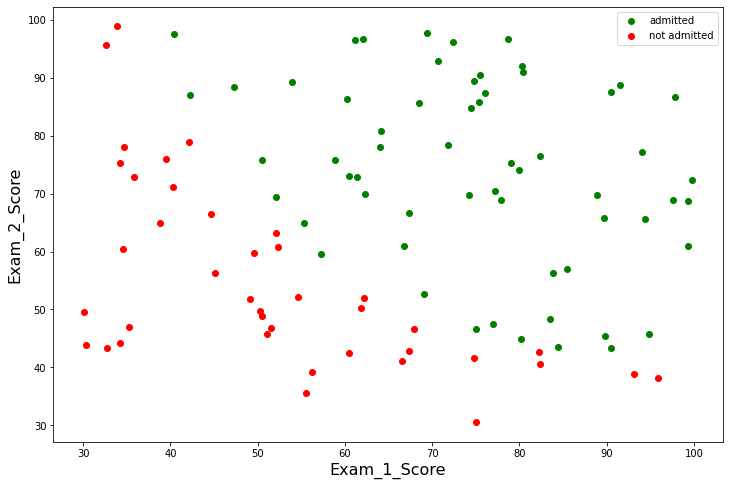

In [179]:
admitted = data.loc[data['Admission_Decision'] == 1]
not_admitted = data.loc[data['Admission_Decision'] == 0]

fig, ax = plt.subplots()
fig.set_size_inches(12, 8)
ax.scatter(admitted['Exam_1_Score'], admitted['Exam_2_Score'], c='green', label='admitted')
ax.scatter(not_admitted['Exam_1_Score'], not_admitted['Exam_2_Score'], c='red', label='not admitted')
ax.legend()

ax.set_xlabel('Exam_1_Score', fontsize=16)
ax.set_ylabel("Exam_2_Score", fontsize=16)

Let's split our dataset into X matrix containing exam results and y vector of training labels
 

In [180]:
X = data.iloc[:,0:2]
y = data.iloc[:,2]

# Add intercept term to X
X.insert(0, 'Ones', 1)

# Convert dataframes to numpy arrays
X = X.to_numpy() # (100, 3)
y = y.to_numpy() # (100,)

# Convert 1D array y to 2D array (column vector)
y = np.reshape(y, (-1, 1)) # (100, 1)

# Initialize fitting parameters
theta = np.zeros((3,1)) # (3, 1)

print(X.shape)
print(y.shape)
print(theta.shape)

(100, 3)
(100, 1)
(3, 1)


Implement sigmoid function


In [181]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

Implement logistic regression cost function

In [182]:
def compute_cost(theta, X, y):

    # Number of training examples
    m = X.shape[0]

    # Sigmoid function input
    z = np.dot(X, theta)

    # Hypothesis (sigmoid function)
    h = sigmoid(z)

    # Cost function
    J = (np.dot(-y.T, np.log(h)) - np.dot((1-y).T, np.log(1-h))) / m
    
    return J.item() 

In [183]:
J = compute_cost(theta, X, y)
print(J)

0.6931471805599453


I will compare two optimization algorithms: gradient descent implemented by myself and SciPy's truncated newton (TNC) implementation.

First I will search for optimal parameters using gradient descent

In [184]:
def gradient_descent(X, y, theta, l_rate, num_iters):
    # List of costs after each gradient descent step
    J_list = []

    # number of training examples 
    m = X.shape[0]

    for i in range(num_iters):
        # Sigmoid function input
        z = np.dot(X, theta)

        # Hypothesis (sigmoid function)
        h = sigmoid(z)

        error = h - y
        theta = theta - l_rate * np.dot(X.T, error) / m

        J_list.append(compute_cost(theta, X, y))

    return (theta, J_list)

In [185]:
l_rate = 0.001
num_iters = 50000
theta, J_list = gradient_descent(X, y, theta, l_rate, num_iters)
print(theta)

[[-2.84946254]
 [ 0.03070169]
 [ 0.0227595 ]]


Plot the convergence graph

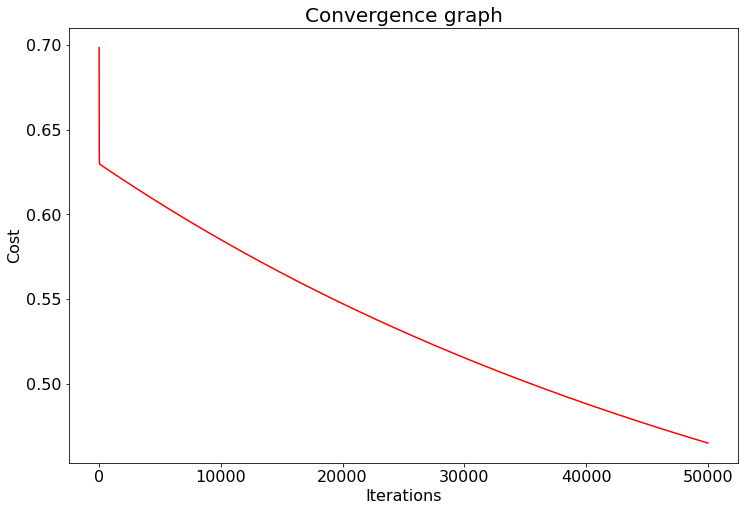

In [186]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 8)
ax.plot(range(num_iters), J_list, c='red')

ax.set_title('Convergence graph', fontsize=20)
ax.set_xlabel('Iterations', fontsize=16)
ax.set_ylabel("Cost", fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)

The cost for parameters learned with gradient descent:

In [187]:
J = compute_cost(theta, X, y)
J

0.46510456912211934


Now let's learn our parameters using SciPy's optimize

We need a function that computes the gradient


In [188]:
def gradient(theta, X, y):
    # Must reshape theta back to 2D because fmin_tnc 
    # truncates it to 1D
    theta = np.reshape(theta, (-1, 1)) # (3, 1) 

    grad = np.zeros_like(theta)

    # Number of training examples
    m = X.shape[0]

    # Sigmoid function input
    z = np.dot(X, theta)

    # Hypothesis (sigmoid function)
    h = sigmoid(z)

    error = h - y
    
    grad = np.dot(X.T, error) / m
    
    return grad

In [189]:
import scipy.optimize as opt

# reinitialize parameters to zeros
theta = np.zeros((3,1)) # (3, 1)

result = opt.fmin_tnc(func=compute_cost, x0=theta, fprime=gradient, args=(X, y))
result

(array([-25.16131846,   0.20623159,   0.20147148]), 36, 0)

Let's compute cost for parameters learned by SciPy's fmin_tnc function

In [190]:
theta = result[0]
J = compute_cost(theta, X, y)
J

0.20349770158947536

As we can see the cost computed with TNC is over two times lower than that computed with my gradient descent.

We can now use our final theta to plot the decision boundary on our training data.


Text(0, 0.5, 'Exam_2_Score')

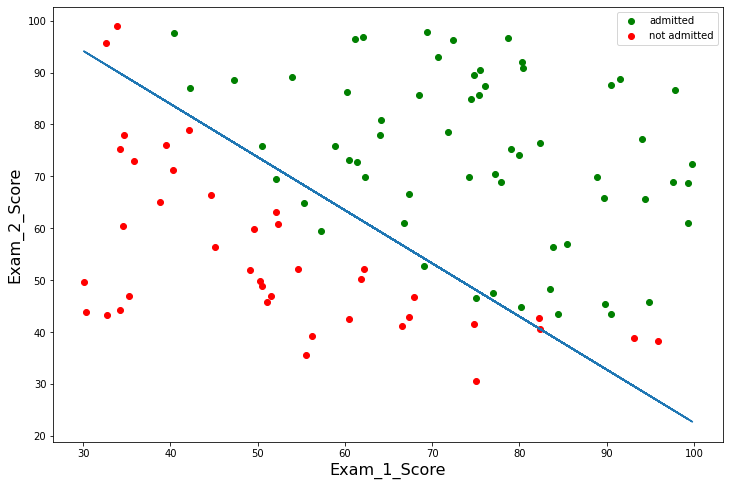

In [193]:
# Computing decision boundary
boundary_vals = [-(theta[0]/theta[2]) - (theta[1]/theta[2])*x for x in data['Exam_1_Score']]

fig, ax = plt.subplots()
fig.set_size_inches(12, 8)
ax.scatter(admitted['Exam_1_Score'], admitted['Exam_2_Score'], c='green', label='admitted')
ax.scatter(not_admitted['Exam_1_Score'], not_admitted['Exam_2_Score'], c='red', label='not admitted')
ax.plot(data['Exam_1_Score'], boundary_vals)
ax.legend()

ax.set_xlabel('Exam_1_Score', fontsize=16)
ax.set_ylabel("Exam_2_Score", fontsize=16)

Let's compute the training set accuracy for our model

In [196]:
def predict(theta, X):

    z = np.dot(X, theta)
    p = np.where(z > 0.5, 1, 0)
    return p  

In [205]:
p = predict(theta, X)
p = np.reshape(p, (-1, 1)) 

train_accuracy = np.mean(p == y) * 100
print('Train Accuracy: {train_accuracy}%'.format(train_accuracy=train_accuracy))

Train Accuracy: 89.0%


Keep in mind this is a training set accuracy, so this number is likely higher than the true performance of our classifier. We should use test set to get a true approximation of the accuracy.